In [1147]:
import pandas as pd
import numpy as np
import altair as alt
import glob
import os
import numpy as np
from scipy import fftpack
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
from scipy.signal import butter, filtfilt
import altair as alt
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as scipy_signal
import pywt
from scipy.stats import wilcoxon
import matplotlib.cm as cm
import numpy as np
from sklearn.utils import resample


alt.data_transformers.disable_max_rows()
fs = 22050

### Definitions

In [2029]:
def read_data(subjid):
    pattern = f"data/*{subjid}*.mat"
    files = glob.glob(pattern)
    print(files)
    
    data = {} # Accumulator
    freq_amp_table = []
    
    # Everything below can go to separate function
    for file in files:
        current_filename = file
        f = h5py.File(current_filename)
                
        ex_data = f['ex']

        freq_by_amp = ex_data[:].shape
        num_tested_freqs = freq_by_amp[1]
        num_tested_amps = freq_by_amp[0]
            
        channel_keys = ['ch1','ch2','ch3','ch4']
        period_keys = ['prestim_sig','stimresp_sig','poststimresp_sig']

        for tested_freqs in range(num_tested_freqs):
            for tested_amps in range(num_tested_amps):
                
                obj = f[ex_data[tested_amps,tested_freqs]]
                if isinstance(obj, h5py.Group): # i.e., checks if the cell actually had a ex template populated or is just [] (no freq, amp, etc. assigned)
                    # Empty arrays in matlab are still seen as datasets, so the way to check if there is anything inside a combo
                    # Is by checking if there are references for the signals at all
                    obj = f[ex_data[tested_amps,tested_freqs]]['electrodes']['ch1']['signals']['stimresp_sig'][:]
                    if obj.dtype == object: # i.e., checks if the cell, which has a populated template, actually has any data in it
                        # It's a group, access the 'decision' dataset inside
                        decision_ref = f[ex_data[tested_amps,tested_freqs]]['decision']
                        decision = f[ex_data[tested_amps,tested_freqs]]['decision'][:]
                        
                        if len(decision.shape) > 0:
                            freq_ref = f[ex_data[tested_amps,tested_freqs]]['frequency']
                            amp_ref = f[ex_data[tested_amps,tested_freqs]]['amplitude']
                            freq = freq_ref[0][0]
                            amp = amp_ref[0][0]
                            
                            freq_amp_table.append([freq,amp])
                            
                            period_len_ref = f[ex_data[tested_amps,tested_freqs]]['electrodes']['ch1']['signals']['stimresp_sig']
                            actual_data = f[period_len_ref[0, 0]][:] #use the first reference address to get actual data
                            period_len = actual_data.shape[0]
                            
                            data[freq,amp] ={'filename': current_filename, 'decision': decision, 'period_len': period_len}
                            # this line creates a new dictionary
                            
                            for channel in channel_keys:
                                sig_ref = f[ex_data[tested_amps,tested_freqs]]['electrodes'][channel]['signals']['stimresp_sig']
                                num_batches = sig_ref.shape[0]
                                all_batches = []
                                for batch in range(num_batches):
                                    sig = []
                                    for period in period_keys:
                                        sig_ref = f[ex_data[tested_amps,tested_freqs]]['electrodes'][channel]['signals'][period]
                                        
                                        if channel == 1:
                                            data[-1]['num_batches'] = num_batches
                                        
                                        sig.append(f[sig_ref[batch][0]][:])
                                    current_batch_all_periods = np.concatenate(sig)
                                    all_batches.append(current_batch_all_periods)
                                
                                # Squeeze out the batches in dataset
                                sig_len = current_batch_all_periods.shape[0]
                                data[freq,amp][channel] = np.array(all_batches).T.transpose(0, 2, 1).reshape(-1, sig_len)
                    else:
                        print(f"{current_filename},{tested_freqs},{tested_amps}, does not have data inside")
                else:
                    print(f"{current_filename},{tested_freqs},{tested_amps}, does not have references")
        
    return data, freq_amp_table

In [ ]:
def pickle_data(subjid):
    np.savez(f'{subjid}_data.npz',
    data=data,
    freq_amp_table=freq_amp_table,
    latency=latency,
    channel_keys=channel_keys)

In [1148]:
def load_data(subjid):
    # example 'hydrolagusColliei_8'
    loaded = np.load(f'/mnt/c/Users/seaudlab/Documents/hydroC/{subjid}_data.npz', allow_pickle=True) # Aoi
    #loaded = np.load(f'{subjid}_data.npz', allow_pickle=True)
    data = loaded['data']
    freq_amp_table = loaded['freq_amp_table']
    latency = loaded['latency'].item()
    channel_keys = loaded['channel_keys'].tolist()
    period_keys = ['prestim','stimresp']
    metric_keys = ['mean','std']
    submetric_keys = ['doub_freq_mag','SNR']
    
    return data, freq_amp_table, latency, channel_keys, period_keys, metric_keys, submetric_keys


In [1149]:
def remove_artefacts(data):
    for coord, dictionary in data.item().items():
        for channel in ['ch1', 'ch2', 'ch3', 'ch4']:
            rms_per_row = np.sqrt(np.mean(dictionary[channel]**2, axis=1))  # Get RMS of each row, axis = 1 means collapse rows
            rms_mean = np.mean(rms_per_row)
            rms_std = np.std(rms_per_row)
            
            # See which rows has an rms that is too high (i.e., artifact) and remove them
            threshold = rms_mean + (rms_std*3)
            keep_rows = rms_per_row <= threshold
            dictionary[channel] = dictionary[channel][keep_rows]
            dictionary[f'{channel}_total_trials'] = dictionary[channel].shape[0]
    
    for coord, dictionary in data.item().items():
        # Determine the minimum number of trials across all channels
        min_trials = min([dictionary[f'{channel}_total_trials'] for channel in ['ch1', 'ch2', 'ch3', 'ch4']])
        
        # Randomly select the same number of trials for each channel
        for channel in ['ch1', 'ch2', 'ch3', 'ch4']:
            # Set a random seed for reproducibility if needed
            np.random.seed(42)
            
            # Get indices for the channel
            channel_indices = np.arange(dictionary[channel].shape[0])
            
            # Randomly select indices
            selected_indices = np.random.choice(channel_indices, size=min_trials, replace=False)
            
            # Update the channel data with selected trials
            dictionary[channel] = dictionary[channel][selected_indices]
            
            # Update the total trials count
            dictionary[f'{channel}_total_trials'] = min_trials
    
    return data

In [1354]:
def select_stimulus(data, myfreq, myamp):
    specific_key = (np.float64(myfreq), np.float64(myamp))
    current_cond = data.item()[specific_key]
    
    return current_cond

In [1504]:
def bandpass(data, low, high, fs, order=4):
    ny = 0.5 * fs
    b, a = butter(order, [low/ny, high/ny], btype='band')
    return filtfilt(b, a, data, axis=1)

#### Analysis definitions

In [1151]:
def add_weights(data, channel_keys, weights):
    weighted_data = {}
    for idx, channel in enumerate(channel_keys):
        current_data = data[channel]
        current_weight = weights[idx]
        weighted_data[channel] = current_data * current_weight
    return weighted_data

In [1152]:
def separate_periods(data, current_cond, period_keys, channel_keys, latency):
    separated_data = {
        'prestim': {},
        'stimresp': {}
    }
    
    period_len = current_cond['period_len']
    
    for period in period_keys:
        for channel in channel_keys:            
            if period == 'prestim':
                separated_data[period][channel] = data[channel][:,latency:latency+period_len]     
            elif period == 'stimresp':
                separated_data[period][channel] = data[channel][:,latency+period_len:latency+period_len*2]
                
    return separated_data

In [1153]:
def compute_fft(data, channel_keys, period_keys,smallest_dim, fs):
    # No channels or periods
    if len(period_keys) == 0 and len(channel_keys) == 0:
        fft_magnitudes = {}
        fft_freq_vecs = {}
        
        trial_magnitudes = []
        freq_vecs = []
        
        if smallest_dim == 1:
            num_cols = data.shape[smallest_dim]
            for trial in range(num_cols):
                cur_trial = data[:,trial]
                n_samples = len(cur_trial)
                # Calculate frequencies for positive frequencies only
                freqs = np.fft.rfftfreq(fs, d=1/fs)
                
                # Calculate magnitude spectrum
                fft_vals = np.fft.rfft(cur_trial,fs)
                magnitude = np.abs(fft_vals)/n_samples
                
                trial_magnitudes.append(magnitude)
                freq_vecs.append(freqs)
                    
                fft_magnitudes = np.vstack(trial_magnitudes)
                fft_freq_vecs = np.vstack(freq_vecs)
    
    # Only have channels        
    elif len(period_keys) == 0 and len(channel_keys) > 0:
        # Initialize dictionaries with nested structure
        fft_magnitudes = {}
        fft_freq_vecs = {}
        
        for channel in channel_keys:
            trial_magnitudes = []
            freq_vecs = []
            num_trial = min(data[channel].shape)
            for trial in range(num_trial):
                cur_trial = data[channel][trial]
                n_samples = len(cur_trial)
                # Calculate frequencies for positive frequencies only
                freqs = np.fft.rfftfreq(fs, d=1/fs)
                
                # Calculate magnitude spectrum
                fft_vals = np.fft.rfft(cur_trial,fs)
                magnitude = np.abs(fft_vals)/n_samples
                
                trial_magnitudes.append(magnitude)
                freq_vecs.append(freqs)
                
            fft_magnitudes[channel] = np.vstack(trial_magnitudes)
            fft_freq_vecs[channel] = np.vstack(freq_vecs)
    
    # Have both period and channel delination
    elif len(period_keys) > 0 and len(channel_keys) > 0: 
        # Initialize dictionaries with nested structure
        fft_magnitudes = {period: {} for period in period_keys}
        fft_freq_vecs = {period: {} for period in period_keys}
        
        for period in period_keys:
            for channel in channel_keys:
                trial_magnitudes = []
                freq_vecs = []
                num_trial = data[period][channel].shape[0]
                
                for trial in range(num_trial):
                    cur_trial = data[period][channel][trial]
                    n_samples = len(cur_trial)
                    # Calculate frequencies for positive frequencies only
                    freqs = np.fft.rfftfreq(fs, d=1/fs)
                    
                    # Calculate magnitude spectrum
                    fft_vals = np.fft.rfft(cur_trial,fs)
                    magnitude = np.abs(fft_vals)/n_samples
                    
                    trial_magnitudes.append(magnitude)
                    freq_vecs.append(freqs)
                    
                fft_magnitudes[period][channel] = np.vstack(trial_magnitudes)
                fft_freq_vecs[period][channel] = np.vstack(freq_vecs)
    
    # Return both dictionaries
    return fft_magnitudes, fft_freq_vecs

In [1154]:
def calc_grand_average(data, period_keys, channel_keys):
    grand_average = {period: {} for period in period_keys}
    grand_std = {period: {} for period in period_keys}
    for period in period_keys: 
        for channel in channel_keys:
            cur_data = data[period][channel]
            cur_avg = np.mean(cur_data, axis=0)
            cur_std = np.std(cur_data, axis=0)
            grand_average[period][channel] = cur_avg
            grand_std[period][channel]=cur_std
    
    grand_data = {
        'average': grand_average,
        'std' : grand_std
    }
    return grand_data

In [1155]:
def plot_fft_grand_mean(grand_data, period_keys, channel_keys, title_prefix='', xlim=None):
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Create a figure with subplots for each period
    fig, axes = plt.subplots(len(period_keys), len(channel_keys), 
                              figsize=(5*len(channel_keys), 4*len(period_keys)), 
                              squeeze=False)
    
    for period_idx, period in enumerate(period_keys):
        for channel_idx, channel in enumerate(channel_keys):
            ax = axes[period_idx, channel_idx]
            
            # Get average and standard deviation
            avg = grand_data['average'][period][channel]
            std = grand_data['std'][period][channel]
            
            # Assuming the frequency vector is passed in or needs to be created
            # This might need adjustment based on how your frequency vector is stored
            freq_vec = np.linspace(0, len(avg), len(avg))
            
            # Plot the mean line
            ax.plot(freq_vec, avg, label='Mean')
            
            # Add shaded standard deviation area
            ax.fill_between(freq_vec, 
                            avg - std, 
                            avg + std, 
                            alpha=0.3, 
                            label='±1 Std Dev')
            
            # Set x-axis limits if provided
            if xlim is not None:
                ax.set_xlim(xlim)
            
            # Formatting
            ax.set_title(f'{title_prefix}{period} - {channel}')
            ax.set_xlabel('Frequency (Hz)')
            ax.set_ylabel('Power')
            ax.legend()
    
    plt.tight_layout()
    return fig

In [1156]:
def find_large_stds(data, freq_vecs, period_keys, channel_keys, metric_keys, myfreq):
    my_rat_data = {}
    my_SNR_data = {}
    target_freq = myfreq*2
    for channel in channel_keys.copy():
        my_rat_data[channel] = []
        cur_avg = data['average']['stimresp'][channel]
        print(len(cur_avg))
        cur_std = data['std']['stimresp'][channel]
        cur_freq_vec = freq_vecs['stimresp'][channel][0]
        
        # Double frequency mask (3 Hz tolerance)
        doub_mask = np.abs(cur_freq_vec - target_freq) <= 3
        my_mean = cur_avg[doub_mask]
        my_std = cur_std[doub_mask]
        my_rat = my_std/my_mean
        my_rat_data[channel].append(my_rat)
        
        print(f"{channel} : {my_rat}")
    
        if my_rat > 6:
            print(f"Warning {channel} has super high std value")
            
    filt_channel_keys = channel_keys

    return my_rat_data, filt_channel_keys

### ICA related defs

In [1157]:
def calculate_diff_CI(data, submetric):
    prestim = data['prestim'][submetric]
    stimresp = data['stimresp'][submetric]
    diff = stimresp - prestim

    # 2. Compute 95% confidence interval for the difference
    lower = float(np.percentile(diff, 2.5))
    upper = float(np.percentile(diff, 97.5))

    print("95% CI:", (lower, upper))

    # 3. Decision rule: if CI excludes 0 → significant
    if lower > 0 or upper < 0:
        print("Groups differ significantly (CI excludes 0).")
    else:
        print("No significant difference (CI includes 0).")
    
    return [lower, upper]

In [1158]:
def reshape_the_data(data, channel_keys, period_keys, bootstrapped=False):
    # Reshape to channel x (trials x samples)
    reshaped_list = []
    for channel in channel_keys:
        cur_set = data[channel]
        reshaped_list.append(cur_set.reshape(-1, 1))
    
    reshaped_data = np.hstack(reshaped_list)
    return reshaped_data

In [1204]:
def perform_ICA(data, channel_keys):
    start = time.perf_counter()
    
    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Improved FastICA configuration
    ica = FastICA(
        n_components=len(channel_keys), 
        random_state=42,  # More robust random seed
        max_iter=500,     # Increased iterations
        tol=1e-4,         # Tightened tolerance???
        whiten='unit-variance'  # Corrected whiten parameter
    )
    
    S = ica.fit_transform(data_scaled)
    A = ica.mixing_

    end = time.perf_counter()
    elasped = end - start
    
    # Convergence check
    print(f"Elapsed time: {elasped:.2f} seconds")
    print(f"ICA Convergence: {ica.n_iter_}")
    
    # Store results in dictionary
    ica_results = {
        'S': S,
        'A': A,
        'n_iter': ica.n_iter_,
        'elapsed_time': elasped
    }
    
    return ica_results

In [1160]:
def select_doub_freq_bin(data, frequencies, period_keys, myfreq, window_size=100):
    if len(period_keys) == 0:
        doub_freq_dict = {}
        
        target_freq = 2*myfreq
        part_window = window_size/2
        artifact_freqs = [myfreq, target_freq, 60, 120, 180, 240, 300, 360, 420, 480, 540]
        freq_vec = frequencies[0]
            
        # Double frequency mask (3 Hz tolerance)
        doub_mask = np.abs(freq_vec - target_freq) <= 3
        print(doub_mask.shape)
        window_mask = (freq_vec >= target_freq-part_window) & (freq_vec <= target_freq+part_window)
        
        for freq in artifact_freqs:
            art_mask = np.abs(freq_vec - freq) <= 3
            window_mask[art_mask] = False
            
        num_it = data.shape[0]

        doub_freq_tmp = []
        snr_tmp = []
        
        for cur_it in range(num_it):
            cur_data = data[cur_it]
            doub_mag = cur_data[doub_mask]
            remain_mag = cur_data[window_mask]
            
            doub_mag = np.mean(doub_mag)
            remain_mag = np.sum(remain_mag)
            
            doub_freq_tmp.append(doub_mag)
            snr_tmp.append(10 * np.log10((doub_mag) / (remain_mag)))
            
        # Move this inside the period loop
        doub_freq_dict = {
            'doub_freq_mag': np.hstack(doub_freq_tmp),
            'SNR': np.hstack(snr_tmp)
        }
        
    elif len(period_keys) > 0:
        doub_freq_dict = {
            'prestim': {},
            'stimresp': {}
        }
            
        target_freq = 2*myfreq
        part_window = window_size/2
        artifact_freqs = [myfreq, target_freq, 60, 120, 180, 240, 300, 360, 420, 480, 540]
        freq_vec = frequencies['prestim']['ch1']
            
        # Double frequency mask (3 Hz tolerance)
        doub_mask = np.abs(freq_vec - target_freq) <= 3
        print(doub_mask.shape)
        window_mask = (freq_vec >= target_freq-part_window) & (freq_vec <= target_freq+part_window)
        
        for freq in artifact_freqs:
            art_mask = np.abs(freq_vec - freq) <= 3
            window_mask[art_mask] = False
            
        num_it = len(data['prestim'])
        doub_mask = doub_mask[0]
        window_mask = window_mask[0]
        
        print(num_it)
        for period in period_keys:
            doub_freq_tmp = []
            snr_tmp = []
            for cur_it in range(num_it):
                cur_data = data[period][cur_it]
                doub_mag = cur_data[doub_mask]
                remain_mag = cur_data[window_mask]
                
                doub_mag = np.mean(doub_mag)
                remain_mag = np.sum(remain_mag)
                
                doub_freq_tmp.append(doub_mag)
                snr_tmp.append(10 * np.log10((doub_mag) / (remain_mag)))
            
            # Move this inside the period loop
            doub_freq_dict[period] = {
                'doub_freq_mag': np.hstack(doub_freq_tmp),
                'SNR': np.hstack(snr_tmp)
            }
            
    return doub_freq_dict

In [1161]:
def create_ICA_weights(data):
    # doub_freq_ICA = data
    weights = []
    snr_db = data['SNR']
    linear_snr = 10**(snr_db/10)
    weights = linear_snr / linear_snr.sum()
    
    return weights

In [1162]:
def weight_and_reconstruct_ica(ica_results, current_cond, channel_keys, components_to_keep, component_weights=None):
    recon_restruct_data = {}
    
    # Extract ICA results
    S = ica_results['S']
    A = ica_results['A']
    
    # Create a weighted reconstruction
    if component_weights is None:
        # If no weights provided, use default (keeping all selected components equally)
        component_weights = np.ones(len(components_to_keep))
    
    # Ensure weights match the number of components to keep
    assert len(component_weights) == len(components_to_keep), "Number of weights must match number of components"
    
    # Filter independent components
    S_filtered = S[:, components_to_keep]
    A_filtered = A[:, components_to_keep]
    
    # Apply weights to the independent components
    S_weighted = S_filtered * component_weights
    
    # Reconstruct the data with weighted components
    reconstructed_data = np.dot(S_weighted, A_filtered.T)
    
    n_trials = current_cond['ch1'].shape[0]
    n_samples_per_trial = current_cond['ch1'].shape[1]
    
    for idx, channel in enumerate(channel_keys):
        recon_restruct_data[channel] = reconstructed_data[:, idx].reshape(n_trials, n_samples_per_trial)  
    
    return recon_restruct_data

### Bootstrapped related

In [1163]:
def collapse_channels(data, period_keys, channel_keys):
    collapsed_dict = {
        'prestim': None,
        'stimresp': None
    }
    for period in period_keys:
        tmp = []
        for channel in channel_keys:
            tmp.append(data[period][channel])
        collapsed_dict[period] = np.vstack(tmp)
        
    return collapsed_dict

In [1164]:
def calculate_bootstrap(data, period_keys, channel_keys, n_iterations, random_state=42):
    # Ensure consistent random sampling across iterations
    rng = np.random.default_rng(random_state)
    # Determine the maximum number of samples across periods
    max_samples = max(len(data[period]) for period in period_keys)

    boot_means = {period: [] for period in period_keys}
    boot_std = {period: [] for period in period_keys}

    for _ in range(n_iterations):
        # Generate a single set of indices to use for all periods
        sample_indices = rng.choice(max_samples, size=max_samples, replace=True)

        for period in period_keys: #%#%#%# Add a stim-prestim "denoised" stimresp here!
            cur_data = data[period]

            # Resample using the same indices for each period
            resampled_data = cur_data[sample_indices % len(cur_data)]

            boot_means[period].append(np.mean(resampled_data, axis=0))
            boot_std[period].append(np.std(resampled_data, axis=0))

    
    return boot_means, boot_std

In [1165]:
def calculate_boot_p(data, submetric):
    # Difference distribution
    prestim = data['prestim'][submetric]
    stimresp = data['stimresp'][submetric]
    diff = stimresp - prestim
    N = len(diff)

    # Proportion of differences > 0 and < 0
    prop_pos = np.sum(diff > 0) / N
    prop_neg = np.sum(diff < 0) / N

    # Two-sided bootstrap p-value
    p_value = 2 * min(prop_pos, prop_neg)

    print("p-value:", float(p_value))

    # Decision rule
    if p_value < 0.05:
        print("Groups differ significantly.")
    else:
        print("No significant difference.")
    
    return p_value


In [1166]:
def denoise_stimresp(data, channel_keys):
    denoised_data = {
        'prestim': {},
        'stimresp': {}
    }
    
    for channel in channel_keys:
        prestim = data['prestim'][channel]
        stimresp = data['stimresp'][channel]
        
        denoised_data['stimresp'][channel] = stimresp-prestim
        denoised_data['prestim'][channel] = prestim
    
    return denoised_data

#### Plotting definitions

In [1167]:
def plot_waveforms(data, channel_keys, title='Check waveforms', num_samples=5, figsize=(8, 4), alpha=0.25):
    if len(channel_keys) == 0:
        num_row = data.shape[1]
        fig, axes = plt.subplots(num_row, 1, figsize=figsize, sharex=True, sharey=True)

        for row_idx in range(num_row):
            ax = axes[row_idx]
            current_data = data[:,row_idx]
            ax.plot(current_data, alpha=alpha)
            
    else:
        fig, axes = plt.subplots(len(channel_keys), 1, figsize=figsize, sharex=True, sharey=True)
        
        if len(channel_keys) == 1:
            axes = [axes]
        
        for row_idx, channel in enumerate(channel_keys):
            ax = axes[row_idx]
            current_data = data[channel]
            
            random_indices = np.random.choice(current_data.shape[0], 
                                            size=min(num_samples, current_data.shape[0]), 
                                            replace=False)
            
            for i in random_indices:
                ax.plot(current_data[i, :], alpha=alpha)
            
            ax.set_ylabel(channel)
    
    fig.suptitle(title)
    fig.tight_layout()
    
    return fig, axes

In [1168]:
def plot_fft(magnitudes, frequencies, myfreq, myamp, subjid, channel_keys, period_keys=period_keys, title='Check waveforms', num_samples=5, figsize=(8, 4), alpha=0.25,xlim=[]):
    if len(channel_keys) == 0:      
        fig, axes = plt.subplots(len(magnitudes), 1, figsize=figsize, sharex=True, sharey=True)
        for row_idx in range(len(magnitudes)):
            ax = axes[row_idx]
            cur_mag = magnitudes[row_idx]
            cur_freq = frequencies[row_idx]
            ax.plot(cur_freq,cur_mag, alpha=alpha)
            
            ax.set_ylabel(str(row_idx))
            ax.set_xlim(xlim)
            
    elif len(channel_keys) > 1 and len(period_keys) == 0:
        fig, axes = plt.subplots(len(channel_keys), 1, figsize=figsize, sharex=True, sharey=True)
        for row_idx, channel in enumerate(channel_keys):
            ax = axes[row_idx]
            cur_mag = magnitudes[channel]
            cur_freq = frequencies[channel]
            
            random_indices = np.random.choice(cur_mag.shape[0], 
                                            size=min(num_samples, cur_mag.shape[0]), 
                                            replace=False)
            
            for i in random_indices:
                ax.plot(cur_freq[i, :],cur_mag[i, :], alpha=alpha)
            
            ax.set_ylabel(channel)
            ax.set_xlim(xlim)
            
    elif len(channel_keys) > 0 and len(period_keys) > 0:
        fig, axes = plt.subplots(len(channel_keys), len(period_keys), figsize=figsize, sharex=True, sharey=True)
        
        for col_idx, period in enumerate(period_keys):
            for row_idx, channel in enumerate(channel_keys):
                ax = axes[row_idx,col_idx]
                cur_mag = magnitudes[period][channel]
                cur_freq = frequencies[period][channel]
                
                random_indices = np.random.choice(cur_mag.shape[0], 
                                                size=min(num_samples, cur_mag.shape[0]), 
                                                replace=False)
                
                for i in random_indices:
                    ax.plot(cur_freq[i, :],cur_mag[i, :], alpha=alpha)
                
                ax.set_ylabel(channel)
                ax.set_xlim(xlim)
    
    
    fig.suptitle(f"{subjid} {myfreq} Hz {myamp} dB: {title}")
    fig.tight_layout()
    plt.savefig(f"{subjid}_{myfreq}Hz_{myamp}dB_{title}.png", 
        format='png', 
        bbox_inches='tight', 
        dpi=300)
    return fig, axes

In [1169]:
def plot_doub_freq_hist(doub_freq_dict, subjid, submetric, myfreq, myamp, bin_num):
    # Create the figure 
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Plot histograms for both periods
    ax.hist(doub_freq_dict['prestim'][submetric], 
            bins=bin_num, 
            alpha=0.5, 
            label='Stim OFF')
    ax.hist(doub_freq_dict['stimresp'][submetric], 
            bins=bin_num, 
            alpha=0.5, 
            label='Stim ON')
    
    ax.set_title(f"{subjid} {myfreq}Hz {myamp}dB")
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Frequency')
    ax.set_yscale('log')
    ax.legend()
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    plt.savefig(f"{subjid}_2x_resp_hist_magnitude_{myfreq}Hz_{myamp}dB.png", 
                format='png', 
                bbox_inches='tight', 
                dpi=300)
    
    # Show the plot and keep it open
    plt.show()

In [1398]:
def plot_bootstrap_fft_comparison(mean_fft_prestim, std_fft_prestim, 
                        mean_fft_stimresp, std_fft_stimresp, 
                        freq_vec, myfreq, xlim=None, ylim=None):
    
    # Create figure with shared axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), 
                                    sharex=True, sharey=True)
    
    # Plot prestim FFT
    ax1.plot(freq_vec, mean_fft_prestim, 'b-', label='Mean FFT')
    ax1.fill_between(freq_vec, 
                      mean_fft_prestim - std_fft_prestim,
                      mean_fft_prestim + std_fft_prestim,
                      alpha=0.3, color='blue', label='±1 STD')
    
    # Add vertical line at 2nd harmonic
    ax1.axvline(myfreq*2, color='black', linestyle='--', 
                alpha=0.7)
    
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Magnitude')
    ax1.set_title('Prestim FFT')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot stimresp FFT
    ax2.plot(freq_vec, mean_fft_stimresp, 'r-', label='Mean FFT')
    ax2.fill_between(freq_vec,
                      mean_fft_stimresp - std_fft_stimresp,
                      mean_fft_stimresp + std_fft_stimresp,
                      alpha=0.3, color='red', label='±1 STD')
    
    # Add vertical line at 2nd harmonic
    ax2.axvline(myfreq*2, color='black', linestyle='--', 
                alpha=0.7)
    
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Magnitude')
    ax2.set_title('Stimresp FFT')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Set x limits if provided
    if xlim is not None:
        ax1.set_xlim(xlim)
        
    if ylim is not None:
        ax1.set_ylim(ylim)
    
    plt.tight_layout()
    plt.show()

### Load data

In [1170]:
subjid = 'hydrolagusColliei_8'
data, freq_amp_table, latency, channel_keys, period_keys, metric_keys, submetric_keys = load_data(subjid)

### What stim combos do we have?

In [1171]:
freq_amp_table_df = pd.DataFrame(freq_amp_table).sort_values(by= [0,1],ascending=True)
freq_amp_table_df

,0,1
30,55.0,90.0
4,55.0,95.0
29,55.0,95.0
3,55.0,100.0
28,55.0,100.0
2,55.0,105.0
27,55.0,105.0
1,55.0,110.0
26,55.0,110.0
0,55.0,115.0


### Data cleaning

In [1172]:
cleaned_data = remove_artefacts(data)

### Select stimulus

(<Figure size 800x400 with 4 Axes>,
 array([<Axes: ylabel='ch1'>, <Axes: ylabel='ch2'>, <Axes: ylabel='ch3'>,
        <Axes: ylabel='ch4'>], dtype=object))

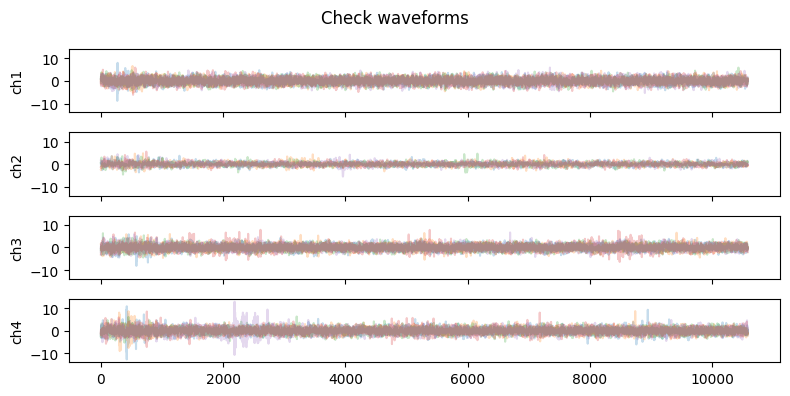

In [2011]:
# Select stimulus
myfreq = 220
myamp = 105
current_cond = select_stimulus(cleaned_data, myfreq, myamp)
plot_waveforms(current_cond, channel_keys, title='Check waveforms', num_samples=5, figsize=(8, 4), alpha=0.25)

In [2012]:
current_cond

{'filename': 'data\\hydrolagusColliei_8_AdaptiveAEP_Ratfish_2506211143_1_run.mat',
 'decision': array([[1.]]),
 'period_len': 3528,
 'ch1': array([[-1.19460072,  0.17554793,  1.54009771, ...,  0.45601636,
         -0.02764442, -0.46301495],
        [ 0.97630309, -0.22984531, -0.29347414, ...,  0.78728288,
          2.13544429,  2.51523436],
        [ 3.24775328,  3.00128633,  2.68255894, ..., -0.087599  ,
          0.11104427, -0.31108726],
        ...,
        [-0.72377069,  0.90649217,  1.94776548, ..., -2.10214268,
         -0.93571127, -0.3863804 ],
        [ 0.17694764, -0.1441126 ,  1.24038316, ..., -0.04665726,
          0.50378172, -1.28558237],
        [-1.69785755, -0.31470319, -0.51748729, ...,  2.94477272,
          2.381503  ,  1.85328454]], shape=(391, 10584)),
 'ch2': array([[-0.00624041, -0.2036006 , -0.51375471, ..., -0.70318317,
         -0.94212665, -1.02424342],
        [-1.00243115, -0.71280623, -0.67565539, ..., -0.64112902,
         -1.12823078, -1.39458539],
   

### Bandpass filter

In [2013]:
low, high = 50, 2000 # Getting rid of junk thats all it is! Don't center on the double frequency response, filtering = bias, base on auditory range, don't introduce that I know what to expect for this given stimulus frequency
filt_data = {}
for channel in channel_keys:
    tmp = []
    cur_data = current_cond[channel]
    tmp.append(bandpass(cur_data, low, high, fs))
    filt_data[channel] = np.hstack(tmp)

In [2014]:
filt_data

{'ch1': array([[ 0.38965948,  1.28774907,  2.08667167, ...,  0.70955496,
          0.23964569, -0.35206951],
        [-0.73836648, -1.00686784, -1.2610932 , ..., -1.44904288,
         -0.89637555, -0.26647641],
        [-0.13855721, -0.87832374, -1.59140368, ...,  0.00234543,
         -0.05534856, -0.12610384],
        ...,
        [ 0.38126192,  0.75848773,  1.0585156 , ..., -0.73741177,
         -0.35846074,  0.12023644],
        [ 0.50177752,  0.26623289,  0.05753326, ...,  0.54988424,
          0.50720475,  0.42341085],
        [ 0.3828751 ,  1.17875405,  1.87273531, ..., -0.22204095,
         -0.10177731, -0.04027275]], shape=(391, 10584)),
 'ch2': array([[-0.07465856, -0.34631151, -0.59880759, ...,  0.66002148,
          0.44003793,  0.22824071],
        [-0.10867207,  0.08318775,  0.2420038 , ...,  0.40115645,
          0.09118038, -0.24103648],
        [-0.53515407, -0.57360386, -0.58158092, ..., -0.41322418,
         -0.1949446 ,  0.02910324],
        ...,
        [-0.08705144

(<Figure size 800x400 with 4 Axes>,
 array([<Axes: ylabel='ch1'>, <Axes: ylabel='ch2'>, <Axes: ylabel='ch3'>,
        <Axes: ylabel='ch4'>], dtype=object))

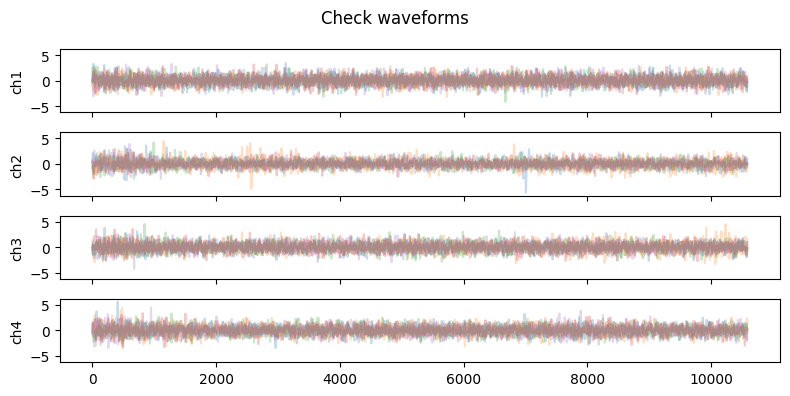

In [2015]:
plot_waveforms(filt_data, channel_keys, 
               title='Check waveforms', num_samples=5, figsize=(8, 4), alpha=0.25)

### ICA

In [2016]:
reshaped_data = reshape_the_data(filt_data, channel_keys, period_keys)
#reshaped_data = reshape_the_data(current_cond, channel_keys, period_keys)
ica_results = perform_ICA(reshaped_data, channel_keys)
input_data = ica_results['S']
ica_fft_magnitudes, ica_fft_freq_vec = compute_fft(
    input_data, channel_keys=[], period_keys=[], smallest_dim = 1, fs=fs)


Elapsed time: 11.76 seconds
ICA Convergence: 13


(<Figure size 800x400 with 4 Axes>,
 array([<Axes: ylabel='0'>, <Axes: ylabel='1'>, <Axes: ylabel='2'>,
        <Axes: ylabel='3'>], dtype=object))

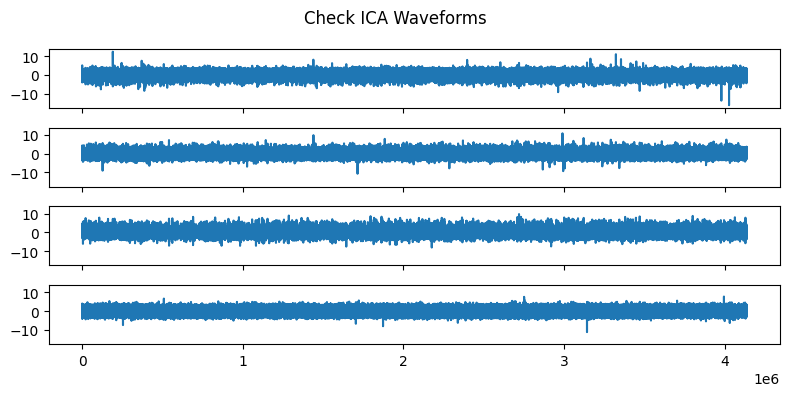

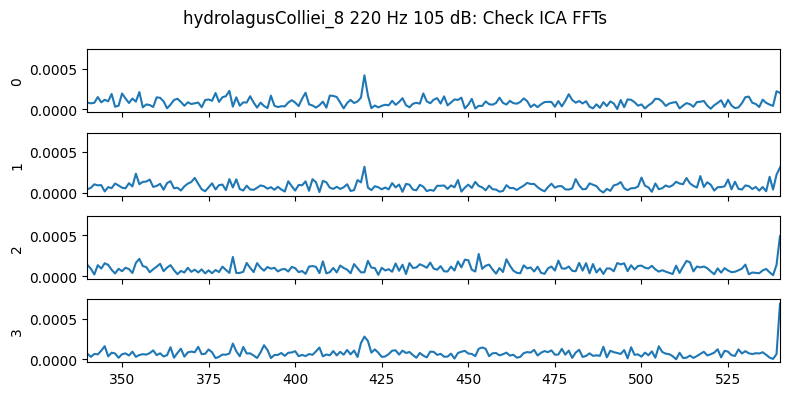

In [2017]:
plot_waveforms(input_data, channel_keys=[], 
               title='Check ICA Waveforms', num_samples=[], figsize=(8, 4), alpha=1.0)
plot_fft(ica_fft_magnitudes, ica_fft_freq_vec, myfreq, myamp, subjid, channel_keys=[], period_keys=[],
         title='Check ICA FFTs', num_samples=5, figsize=(8, 4), alpha=1.0,xlim=[myfreq*2-100,myfreq*2+100])


In [2018]:
ica_doub_freq = select_doub_freq_bin(ica_fft_magnitudes, ica_fft_freq_vec, [], myfreq, window_size=100)
weights = create_ICA_weights(ica_doub_freq)
recon_restruct_data = weight_and_reconstruct_ica(ica_results, current_cond, channel_keys, [0,1,2,3], component_weights=None)
weights

(11026,)


array([0.3722582 , 0.18831632, 0.25539711, 0.18402838])

### Add weights to time domain trials

In [2019]:
# weights = [0.25,0.25,0.25,0.25]
# weighted_data = add_weights(current_cond, channel_keys, weights)

### Separate denoised data

(<Figure size 800x400 with 8 Axes>,
 array([[<Axes: ylabel='ch1'>, <Axes: ylabel='ch1'>],
        [<Axes: ylabel='ch2'>, <Axes: ylabel='ch2'>],
        [<Axes: ylabel='ch3'>, <Axes: ylabel='ch3'>],
        [<Axes: ylabel='ch4'>, <Axes: ylabel='ch4'>]], dtype=object))

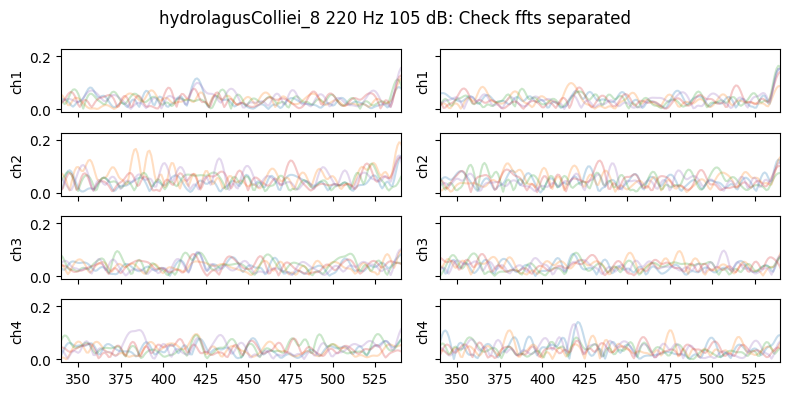

In [2020]:
separated_data = separate_periods(recon_restruct_data, current_cond, period_keys, channel_keys, latency)

# Safe
weighted_ffts, weighted_freq_vec = compute_fft(separated_data, channel_keys, period_keys, smallest_dim=[], fs=fs)

# Risky signal subtraction here...
# denoised_data = denoise_stimresp(separated_data, channel_keys)
# weighted_ffts, weighted_freq_vec = compute_fft(denoised_data, channel_keys, period_keys, smallest_dim=[], fs=fs)

plot_fft(weighted_ffts, weighted_freq_vec, myfreq, myamp, subjid, channel_keys,
            period_keys=period_keys, 
            title='Check ffts separated', 
            num_samples=5, 
            figsize=(8, 4), 
            alpha=0.25,
            xlim=[myfreq*2-100,myfreq*2+100]
)

In [2021]:
collapsed_dict = collapse_channels(weighted_ffts, period_keys, channel_keys)


In [2022]:
bootstrap_means, bootstrap_stds = calculate_bootstrap(
    collapsed_dict, period_keys, channel_keys,
    n_iterations=100)


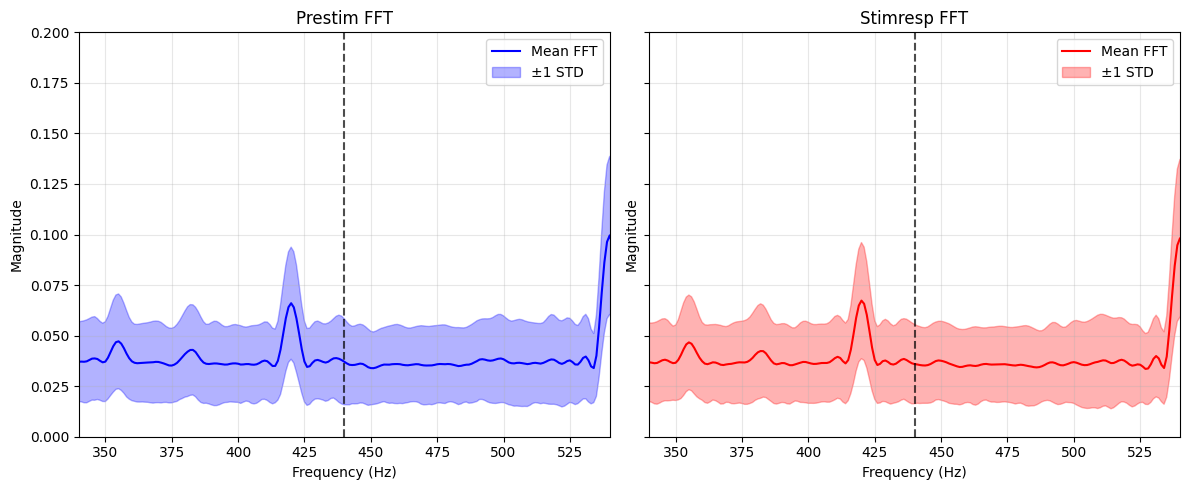

In [2023]:
current_avg = 3
mean_fft_prestim = bootstrap_means['prestim'][current_avg]
std_fft_prestim = bootstrap_stds['prestim'][current_avg]

mean_fft_stimresp = bootstrap_means['stimresp'][current_avg]
std_fft_stimresp = bootstrap_stds['stimresp'][current_avg]

freq_vec = weighted_freq_vec['prestim']['ch1'][current_avg]

plot_fft_comparison(mean_fft_prestim, std_fft_prestim, 
                        mean_fft_stimresp, std_fft_stimresp, 
                        freq_vec, myfreq, xlim=[myfreq*2-100,myfreq*2+100], ylim=[0.0,0.2])


### Calculate bootstrapped SNR by period

In [2024]:
doub_freq_dict = select_doub_freq_bin(bootstrap_means, weighted_freq_vec, period_keys, myfreq, window_size=100)

(391, 11026)
100


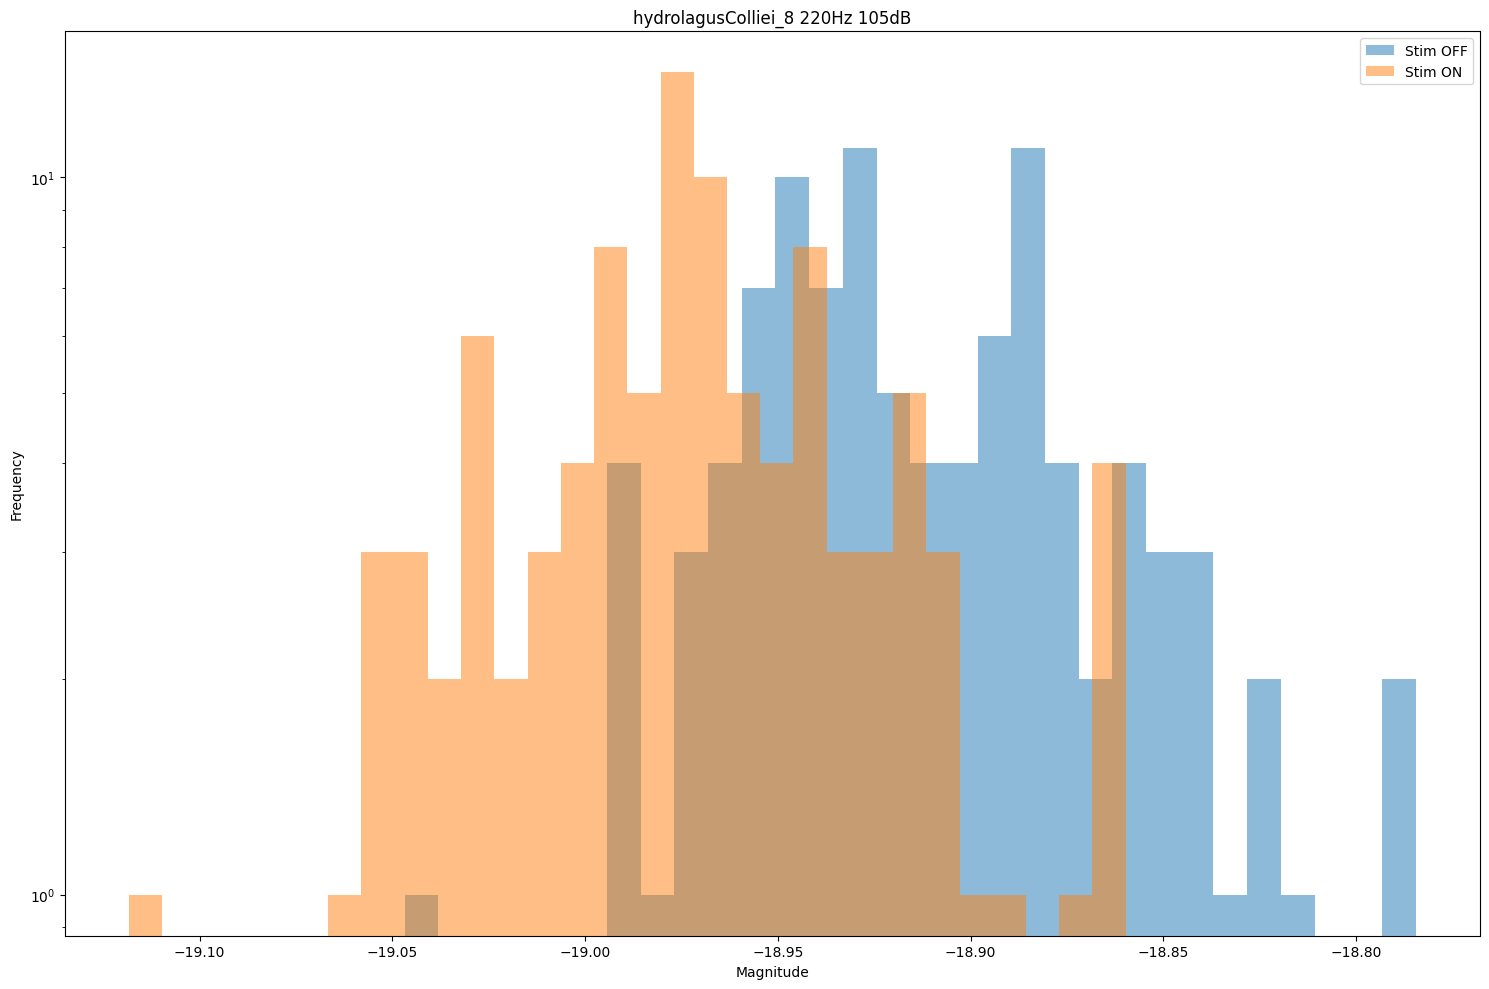

In [2025]:
plot_doub_freq_hist(doub_freq_dict, subjid, 'SNR', myfreq, myamp, 30)

In [2026]:
diff_CI_results = calculate_diff_CI(doub_freq_dict, 'SNR')

95% CI: (-0.1758918525548685, 0.054875412670052345)
No significant difference (CI includes 0).


In [2027]:
p_value = calculate_boot_p(doub_freq_dict, 'SNR')
float(p_value)
"{:e}".format(p_value)

p-value: 0.42
No significant difference.


'4.200000e-01'

In [2028]:
# Denoise/Make best use of all channels
# by applying weights to each channel based on how stable their mean estimate of
# the double frequency response

# Artefact rejection

# Step 1: Add weights to per trial time domain signals by channel 
# Step 2: Conduct ffts on per trial basis on the weighted trials as one mega-channel
# Step 3: In FFT land, calculate the difference between stim and prestim on trial by trial basis
# Step 4: Take the mean on the differences
# Step 5: Calculate the standard deviation as well (optimize around reducing S as much as possible)
# Step 6: Calculate ICA

# After determining weights and performing ICA based denoising...
# Step 6: Bootstrap: Take the data generated from step 2, conduct bootstrap averaging per period, create a distribution of estimates of SNR for each period
# Step 7: 95% CI of the differences between prestim and stimresp
